### Code Dependencies

In [1]:
!pip install nnfs

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

In [3]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Prior size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

print ("Current size:", fig_size)

Prior size: [6.0, 4.0]
Current size: [12, 9]


### Training Data

In [4]:
galaxy_arm_coordinates, galaxy_arm_class = spiral_data(
    samples=100, 
    classes=3
)

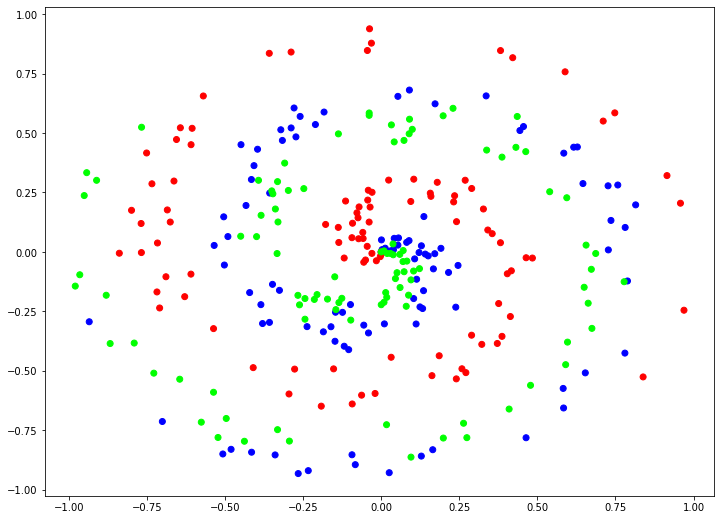

In [5]:
plt.scatter(
    galaxy_arm_coordinates[:, 0],
    galaxy_arm_coordinates[:, 1],
    c=galaxy_arm_class,
    cmap='brg'
)

plt.show()

### Model Architecture Classes

Note: in the later sections, we’ll be adding more loss functions and some of the operations that we’ll be performing are common for all of them. 

One of these operations is how we calculate the overall loss — no matter which loss function we’ll use, **the overall loss is always the mean of all sample losses**.

In [6]:
class Layer_Dense:

    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):        
        self.output = np.dot(inputs, self.weights) + self.biases


class Activation_ReLU:
    
    def forward(self, inputs):        
        self.output = np.maximum(0, inputs)


class Activation_Softmax:
    
    def forward(self, inputs):

        # Subtract the max and get unnormalized probabilities
        exp_values = np.exp(
            inputs - np.max(
                inputs, 
                axis=1,
                keepdims=True
            )
        )
        
        # Normalize them for each sample
        probabilities = exp_values / np.sum(
            exp_values, 
            axis=1,
            keepdims=True
        )

        self.output = probabilities


class Loss:

    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        return data_loss


# Categorical cross-entropy loss inherits from Loss
class Loss_CategoricalCrossentropy(Loss):

    def forward(self, y_pred, y_true):

        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped*y_true,
                axis=1
            )
        
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

### Spirial Arm Classification Model Construction 

In [7]:
# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

loss_function = Loss_CategoricalCrossentropy()

### Forward Pass

In [8]:
dense1.forward(galaxy_arm_coordinates)
activation1.forward(dense1.output)

dense2.forward(activation1.output)
activation2.forward(dense2.output)

loss = loss_function.calculate(activation2.output, galaxy_arm_class)

In [9]:
print('loss:', loss)

loss: 1.0986104


## Accuracy Calculation


While **loss** is a useful metric for **optimizing** a model, the metric commonly used in practice, along with loss, is the **accuracy**. 

Accuracy describes how often the largest confidence is the correct class in terms of a fraction.

Note, we don't use this metric for optimization etc. but rather as a metric to keep track of.

### Example usage

In [10]:
softmax_outputs = np.array([
    [0.7, 0.2, 0.1],
    [0.5, 0.1, 0.4],
    [0.02, 0.9, 0.08]]
)

class_targets = np.array([0, 1, 1])

In [11]:
predictions = np.argmax(softmax_outputs, axis=1)

predictions

array([0, 0, 1])

In [12]:
predictions == class_targets

array([ True, False,  True])

In [13]:
np.mean(predictions==class_targets)

# np.mean() casts it to [1, 0, 1] and calculates mean, which is 0.(6)

0.6666666666666666

### Adding to our code

In [14]:
predictions = np.argmax(activation2.output, axis=1)

# If targets are one-hot encoded, convert them:
if len(galaxy_arm_class.shape) == 2:
    y = np.argmax(galaxy_arm_class, axis=1)

accuracy = np.mean(predictions==galaxy_arm_class)

# Print accuracy
print('acc:', accuracy)

acc: 0.34
